# MODNet 'matbench_steels' benchmarking

The `matbench_steels` dataset from [Citrination](https://citrination.com/datasets/153092/) (contributed by Gareth Conduit, University of Cambridge) contains the composition of ~800 steels and some measured properties with variable coverage. The dataset `matbench_steels` as made available by matminer has de-duplicated the steels down to ~312 samples, and provides only the measured yield strength, the property with 100% coverage.

In [41]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Markdown
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
#from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
import modnet
modnet.__version__

'0.1.8'

In [6]:
Markdown(filename="./README.md")

# matbench_steels

## Introduction

- Small dataset of only 312 steel compositions with associated yield strengths.

Results to beat:

| Method | Yield strength (MPa) |
|:-------|-----------------:|
| AM     | 95.2 |
| RF     | 104  |
| Dummy  | 230  |

## Notes

- Extremely variable depending on validation set; probably high degree of bias in underlying data.
- Extremely well-behaved learning curves, consistently ~50 MPa on test set but double that on validation set.
- Errors are very long-tailed
- Should really consider doing feature importance with left-out data

## To-do

- [x] Featurize
- [x] Feature selection 
- [x] Baseline models
- [ ] Feature importance

## Results

| Method | Yield strength (MPa) |
|:-------|---------------------:|
| Rough MODNet baseline   | 107.8 |


## Data exploration

In [7]:
df = load_dataset("matbench_steels")
df["composition"] = df["composition"].map(Composition)

In [ ]:
df.columns

### Composition space

In [ ]:
values = df["composition"].apply(lambda s: s.get_el_amt_dict())
elements = defaultdict(float)
proportions = defaultdict(list)
for s in values:
    for e in s:
        elements[e] += s[e]
        proportions[e] += [s[e]]
        
for elem in elements:
    elements[elem] /= len(values)

mean_proportions = {elem: np.mean(proportions[elem]) for elem in proportions}
mean_proportions = dict(sorted(mean_proportions.items(), key=lambda x: x[1], reverse=True))
elements = dict(sorted(elements.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(facecolor="w");
ax.set_yscale("log")
ax.bar(elements.keys(), elements.values())
ax.set_ylabel("Average concentration of element in dataset");

In [ ]:
# distribution of element proportions across compositions
fig, ax = plt.subplots(4, 4, facecolor="w", figsize=(10, 10))
for axis, elem in zip(itertools.product(range(0, 4), repeat=2), mean_proportions):
    axis = (axis[1], axis[0])
    ax[axis].hist(
        proportions[elem], 
        bins=np.linspace(0, 1, 50), 
        density=False, 
    )
    ax[axis].set_xlim(-0.1, 1.1)
    ax[axis].text(0.75, 0.8, elem, fontsize=24, transform=ax[axis].transAxes, )
    ax[axis].set_ylim(0, 312)

plt.tight_layout()

### Target space

In [ ]:
df.describe()

In [ ]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["yield strength"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("Yield strength (GPa)")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [9]:
class CompositionOnlyFeaturizer(MODFeaturizer):
    composition_featurizers = DeBreuck2020Featurizer.composition_featurizers
    
    def featurize_composition(self, df):
        """ Applies the preset composition featurizers to the input dataframe,
        renames some fields and cleans the output dataframe.

        """
        from pymatgen.core.periodic_table import Element 
        import numpy as np
        from modnet.featurizers import clean_df
        df = super().featurize_composition(df)
        _orbitals = {"s": 1, "p": 2, "d": 3, "f": 4}
        df['AtomicOrbitals|HOMO_character'] = df['AtomicOrbitals|HOMO_character'].map(_orbitals)
        df['AtomicOrbitals|LUMO_character'] = df['AtomicOrbitals|LUMO_character'].map(_orbitals)

        df['AtomicOrbitals|HOMO_element'] = df['AtomicOrbitals|HOMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )
        df['AtomicOrbitals|LUMO_element'] = df['AtomicOrbitals|LUMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )

        df = df.replace([np.inf, -np.inf, np.nan], 0)
        
        return clean_df(df)

class CompositionContainer:
    def __init__(self, composition):
        self.composition = composition

In [10]:
PRECOMPUTED_MODDATA = "./precomputed/steel_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_steels")
    df["composition"] = df["composition"].map(Composition)
    df["structure"] = df["composition"].map(CompositionContainer)
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["yield strength"].tolist(), 
        target_names=["yield strength (MPa)"],
        featurizer=CompositionOnlyFeaturizer(n_jobs=8)
    )
    data.featurize()
    # As this is a small data/feature set, order all features 
    data.feature_selection(n=-1)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f0b52222580> object, created with modnet version 0.1.8~develop


In [ ]:
#data.optimal_features=None
#data.cross_nmi = None
#data.num_classes = {"yield strength (GPa)":0}
#data.feature_selection(n=-1)
#data.save("./precomputed/steel_benchmark_moddata_MPCNMI.pkl.gz")

In [ ]:
# Look at some of the top features chosen by MODNet
for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("Yield strength (MPa)")

## Training

This is a very small dataset, so we must make judicious use of what data there is. First, let's generate test folds according to [matbench's suggestions](https://hackingmaterials.lbl.gov/automatminer/datasets.html#benchmarking-and-reporting-your-algorithm):

In [45]:
from modnet.matbench.benchmark import matbench_benchmark
from modnet.model_presets import gen_presets

presets = gen_presets(len(data.get_optimal_descriptors()), 0.8*0.8*len(data.df_featurized))
for ind, preset in enumerate(presets):
    presets[ind]["lr"] /= 5

data.df_targets.rename(columns={"yield strength (GPa)": "sigma"}, inplace=True)

best_settings = {
    "increase_bs":False,
    "num_neurons": [[64], [32], [8], [8]],
    "n_feat": len(data.get_optimal_descriptors()),
    "lr": 0.005,
    "epochs": 500,
    "verbose": 0,
    "act": "elu",
    "batch_size": 32,
    "loss": "mae",
    "xscale": "standard",
}

results = matbench_benchmark(data, [[["sigma"]]], {"sigma": 1}, best_settings,save_folds=True, presets=presets)
np.mean(results['scores'])

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f0788689310> object, created with modnet version 0.1.8
INFO:root:Data successfully saved as folds/train_moddata_f1!
INFO:root:Training preset #1/24: {'batch_size': 32, 'lr': 0.002, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 138.728
INFO:root:Training preset #2/24: {'batch_size': 32, 'lr': 0.001, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 163.387
INFO:root:Training preset #3/24: {'batch_size': 64, 'lr': 0.002, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 137.622
INFO:root:Training preset #4/24: {'batch_size': 64, 'lr': 0.00

Model #1: MAE = 96.34886648995534


INFO:root:Data successfully saved as folds/train_moddata_f2!
INFO:root:Training preset #1/24: {'batch_size': 32, 'lr': 0.002, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 121.060
INFO:root:Training preset #2/24: {'batch_size': 32, 'lr': 0.001, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 133.315
INFO:root:Training preset #3/24: {'batch_size': 64, 'lr': 0.002, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 111.725
INFO:root:Training preset #4/24: {'batch_size': 64, 'lr': 0.001, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Comp

Model #2: MAE = 94.05622674851192


INFO:root:Data successfully saved as folds/train_moddata_f3!
INFO:root:Training preset #1/24: {'batch_size': 32, 'lr': 0.002, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 137.686
INFO:root:Training preset #2/24: {'batch_size': 32, 'lr': 0.001, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 149.889
INFO:root:Training preset #3/24: {'batch_size': 64, 'lr': 0.002, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 106.847
INFO:root:Training preset #4/24: {'batch_size': 64, 'lr': 0.001, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Comp

Model #3: MAE = 81.01807113155242


INFO:root:Data successfully saved as folds/train_moddata_f4!
INFO:root:Training preset #1/24: {'batch_size': 32, 'lr': 0.002, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 97.312
INFO:root:Training preset #2/24: {'batch_size': 32, 'lr': 0.001, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 227.926
INFO:root:Training preset #3/24: {'batch_size': 64, 'lr': 0.002, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 220.327
INFO:root:Training preset #4/24: {'batch_size': 64, 'lr': 0.001, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compi

Model #4: MAE = 101.09657730594759


INFO:root:Data successfully saved as folds/train_moddata_f5!
INFO:root:Training preset #1/24: {'batch_size': 32, 'lr': 0.002, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 110.512
INFO:root:Training preset #2/24: {'batch_size': 32, 'lr': 0.001, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 134.002
INFO:root:Training preset #3/24: {'batch_size': 64, 'lr': 0.002, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Validation loss: 142.572
INFO:root:Training preset #4/24: {'batch_size': 64, 'lr': 0.001, 'n_feat': 30, 'num_neurons': [[60], [30], [7], [7]], 'epochs': 1000, 'loss': 'mae', 'act': 'elu'}
INFO:root:Comp

Model #5: MAE = 120.72307187972531


98.64856271113851

In [17]:
results["models"][0].history.history.keys()

dict_keys(['loss', 'mae'])

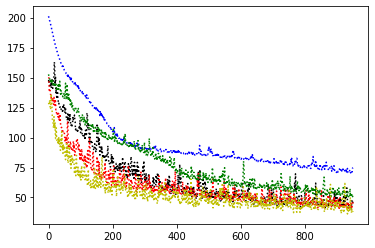

In [19]:
for i,c in zip(range(5),['b','k','r','g','y']):
    #plt.plot(results["models"][i].history.history["loss"][50:],c=c)
    plt.plot(results["models"][i].history.history["mae"][50:],':',c=c)

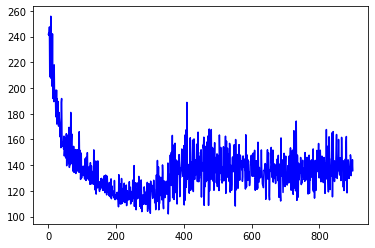

In [35]:
for i,c in zip(range(1),['b','k','r','g','y']):
    for j in range(8, 9):
        #plt.plot(results["models"][i].history.history["loss"][50:],c=c)
        plt.plot(results["all_nested_models"][i][j].history.history["val_loss"][100:], c=c)

KeyError: 'val_loss'

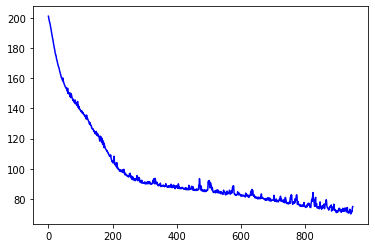

In [20]:
for i,c in zip(range(5),['b','k','r','g','y']):
    plt.plot(results["models"][i].history.history["loss"][50:],c=c)
    plt.plot(results["models"][i].history.history["val_loss"][50:],':',c=c)

In [ ]:
for i,c in zip(range(5),['b','k','r','g','y']):
    plt.plot(results["models"][i].history.history["loss"][50:],c=c)
    plt.plot(results["models"][i].history.history["val_loss"][50:],':',c=c)

In [ ]:
import seaborn as sns
reg_df = pd.DataFrame(
    np.array([
        [x for targ in results["targets"] for x in targ],
        [y for pred in results["predictions"] for y in pred],
        [e for err in results["errors"] for e in err]
    ]).T,
    columns=["targets", "predictions", "errors"]
)
splits = []
for i in range(5):
    for j in range(len(results["targets"][i])):
        splits.append(i)
reg_df["split"] = splits

In [ ]:
fig, ax = plt.subplots()
#ax.set_aspect("equal")
sns.scatterplot(data=reg_df, x="targets", y="predictions", hue="split", palette="Dark2", ax=ax, alpha=0.5)
sns.regplot(data=reg_df, x="targets", y="predictions", ax=ax, scatter=False, color="k")
# plt.plot(*ax.get_xlim(), *ax.get_xlim(), c="k",alpha=0.5)
plt.xlabel("True")
plt.ylabel("Pred.")

In [ ]:
g = sns.jointplot(data=reg_df, x="targets", y="predictions", hue="split", palette="Dark2", alpha=0.0, marginal_kws={"shade": False})
g.plot_joint(sns.scatterplot, hue=None, c="black", s=5, alpha=0.8)
g.plot_joint(sns.kdeplot, color="split", zorder=0, levels=5, alpha=0.5)

## Feature selection

In [ ]:
def process(data):
    x = data.get_featurized_df()[model.optimal_descriptors[:model.n_feat]]
    x = model._scaler.transform(x)
    x = np.nan_to_num(x)
    return x

In [ ]:
try:
    matbench_kfold_splits()
except:
    os.chdir("..")
    from modnet_matbench.utils import matbench_kfold_splits


In [ ]:
import shap
shap.initjs()
for train, test in matbench_kfold_splits(data):
    train_moddata, test_moddata = data.split((train, test))
    break

X_train = shap.sample(process(train_moddata))
explainer = shap.KernelExplainer(model.model.predict, X_train)

In [ ]:
shap_values = explainer.shap_values(X_train, nsamples=1000)

In [ ]:
shap.force_plot(
    explainer.expected_value, 
    shap_values[0], 
    feature_names=model.optimal_descriptors[:model.n_feat], 
    out_names=["Yield strength (GPa)"],
)

In [ ]:
shap.summary_plot(shap_values[0], X_train, max_display=32, plot_type="dot", feature_names=model.optimal_descriptors[:model.n_feat])